## Derivative Filtering

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class PIDController:
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.prev_error = 0
        self.integral = 0
        
    def compute(self, setpoint, pv, dt):
        error = setpoint - pv
        
        # Proportional term
        P = self.Kp * error
        
        # Integral term
        self.integral += error * dt
        I = self.Ki * self.integral
        
        # Derivative term
        derivative = (error - self.prev_error) / dt
        D = self.Kd * derivative
        
        # Save error for next derivative calculation
        self.prev_error = error
        
        # Compute output
        output = P + I + D
        
        return output

In [3]:
class PIDControllerWithFilter(PIDController):
    def __init__(self, Kp, Ki, Kd, tau=0.1):
        super().__init__(Kp, Ki, Kd)
        self.tau = tau  # filter time constant
        self.derivative_filtered = 0
        
    def compute(self, setpoint, pv, dt):
        error = setpoint - pv
        
        # Proportional term
        P = self.Kp * error
        
        # Integral term
        self.integral += error * dt
        I = self.Ki * self.integral
        
        # Derivative term with filtering
        derivative = (error - self.prev_error) / dt
        # Apply low-pass filter
        alpha = dt / (self.tau + dt)
        self.derivative_filtered = (1 - alpha) * self.derivative_filtered + alpha * derivative
        D = self.Kd * self.derivative_filtered
        
        # Save error for next derivative calculation
        self.prev_error = error
        
        # Compute output
        output = P + I + D
        
        return output

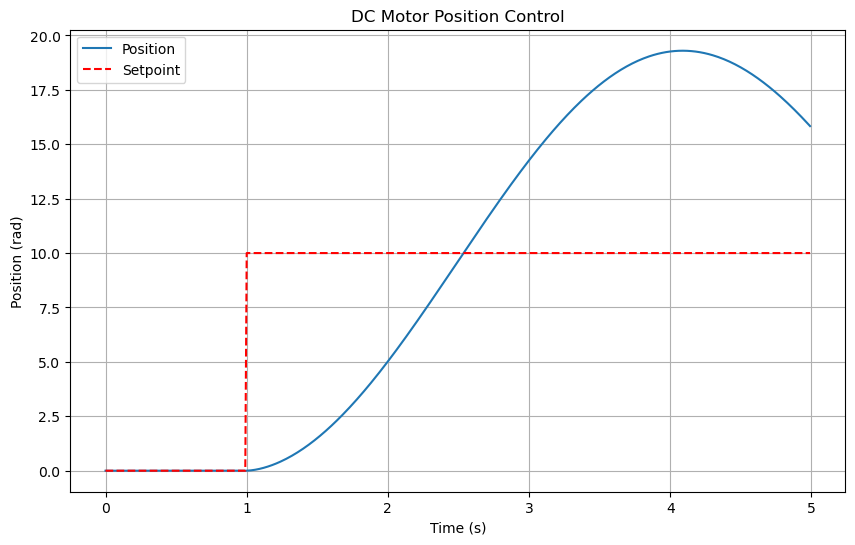

In [4]:
class DCMotor:
    def __init__(self):
        self.position = 0
        self.velocity = 0
        self.resistance = 1.0
        self.inductance = 0.5
        self.torque_constant = 0.1
        self.inertia = 0.2
        self.damping = 0.05
        
    def update(self, voltage, dt):
        # Simplified motor model
        current = voltage / self.resistance  # ignoring inductance for simplicity
        torque = self.torque_constant * current
        acceleration = (torque - self.damping * self.velocity) / self.inertia
        self.velocity += acceleration * dt
        self.position += self.velocity * dt
        return self.position

# Simulation
motor = DCMotor()
pid = PIDControllerWithFilter(Kp=2, Ki=0.5, Kd=0.1, tau=0.05)

dt = 0.01
total_time = 5
steps = int(total_time / dt)
time = np.arange(0, total_time, dt)
position = np.zeros_like(time)
setpoint = np.zeros_like(time)

# Step input
setpoint[100:] = 10  # after 1 second

for i in range(1, len(time)):
    control = pid.compute(setpoint[i], motor.position, dt)
    position[i] = motor.update(control, dt)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(time, position, label='Position')
plt.plot(time, setpoint, 'r--', label='Setpoint')
plt.xlabel('Time (s)')
plt.ylabel('Position (rad)')
plt.title('DC Motor Position Control')
plt.legend()
plt.grid(True)
plt.show()